In [102]:

!pip install haversine

In [265]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine, Unit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [266]:
df = pd.read_csv("uber.csv")


In [267]:
df.head()


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [268]:
df = df[['pickup_datetime', 'pickup_longitude', 'pickup_latitude',
         'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'fare_amount']]
df

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
0,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,7.5
1,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,7.7
2,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,12.9
3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,5.3
4,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,16.0
...,...,...,...,...,...,...,...
199995,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1,3.0
199996,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1,7.5
199997,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2,30.9
199998,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1,14.5


In [269]:
df = df.dropna()
df = df[(df['fare_amount'] > 0) & (df['fare_amount'] < 500)]
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 6)]

In [270]:
df=df[
(df['pickup_latitude'].between(-90,90)) &
(df['dropoff_latitude'].between(-90,90)) &
(df['pickup_longitude'].between(-180,180)) &
(df['dropoff_longitude'].between(-180,180))

]

In [271]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
pickup_longitude,199256.0,-72.504173,10.442243,-93.824668,-73.992063,-73.981825,-73.967162,40.808425
pickup_latitude,199256.0,39.919172,6.127757,-74.015515,40.734794,40.752582,40.767155,48.018760
dropoff_longitude,199256.0,-72.514408,10.403044,-75.458979,-73.991409,-73.980094,-73.963663,40.831932
dropoff_latitude,199256.0,39.923484,6.114307,-74.015750,40.733828,40.753041,40.767995,45.031598
passenger_count,199256.0,1.689440,1.305386,1.000000,1.000000,1.000000,2.000000,6.000000
fare_amount,199256.0,11.369376,9.905986,0.010000,6.000000,8.500000,12.500000,499.000000


In [272]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199256 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    199256 non-null  object 
 1   pickup_longitude   199256 non-null  float64
 2   pickup_latitude    199256 non-null  float64
 3   dropoff_longitude  199256 non-null  float64
 4   dropoff_latitude   199256 non-null  float64
 5   passenger_count    199256 non-null  int64  
 6   fare_amount        199256 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 12.2+ MB


In [273]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df = df.dropna(subset=['pickup_datetime'])
df['hour'] = df['pickup_datetime'].dt.hour
df['day'] = df['pickup_datetime'].dt.day
df['month'] = df['pickup_datetime'].dt.month

In [274]:
df

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,hour,day,month
0,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,7.5,19,7,5
1,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,7.7,20,17,7
2,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,12.9,21,24,8
3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,5.3,8,26,6
4,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,16.0,17,28,8
...,...,...,...,...,...,...,...,...,...,...
199995,2012-10-28 10:49:00+00:00,-73.987042,40.739367,-73.986525,40.740297,1,3.0,10,28,10
199996,2014-03-14 01:09:00+00:00,-73.984722,40.736837,-74.006672,40.739620,1,7.5,1,14,3
199997,2009-06-29 00:42:00+00:00,-73.986017,40.756487,-73.858957,40.692588,2,30.9,0,29,6
199998,2015-05-20 14:56:25+00:00,-73.997124,40.725452,-73.983215,40.695415,1,14.5,14,20,5


In [275]:
def calc_distance(row):
    try:
        p1 = (row['pickup_latitude'], row['pickup_longitude'])
        p2 = (row['dropoff_latitude'], row['dropoff_longitude'])
        return haversine(p1, p2, unit=Unit.KILOMETERS)
    except:
        return np.nan

In [276]:
df['distance_km'] = df.apply(calc_distance, axis=1)
df = df.dropna(subset=['distance_km'])
df = df[(df['distance_km'] > 0.1) & (df['distance_km'] < 100)]

In [277]:
df


,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,hour,day,month,distance_km
0,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,7.5,19,7,5,1.683325
1,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,7.7,20,17,7,2.457593
2,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,12.9,21,24,8,5.036384
3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,5.3,8,26,6,1.661686
4,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,16.0,17,28,8,4.475456
...,...,...,...,...,...,...,...,...,...,...,...
199995,2012-10-28 10:49:00+00:00,-73.987042,40.739367,-73.986525,40.740297,1,3.0,10,28,10,0.112210
199996,2014-03-14 01:09:00+00:00,-73.984722,40.736837,-74.006672,40.739620,1,7.5,1,14,3,1.875053
199997,2009-06-29 00:42:00+00:00,-73.986017,40.756487,-73.858957,40.692588,2,30.9,0,29,6,12.850337
199998,2015-05-20 14:56:25+00:00,-73.997124,40.725452,-73.983215,40.695415,1,14.5,14,20,5,3.539720


In [278]:
Q1 = df['fare_amount'].quantile(0.25)
Q3 = df['fare_amount'].quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

In [279]:

df = df[(df['fare_amount'] >= lower_limit) & (df['fare_amount'] <= upper_limit)]
print("After Outlier Removal:", df.shape)

After Outlier Removal: (175718, 11)



Correlation with Fare Amount:
 fare_amount        1.000000
distance_km        0.724921
passenger_count    0.012615
hour              -0.013544
Name: fare_amount, dtype: float64


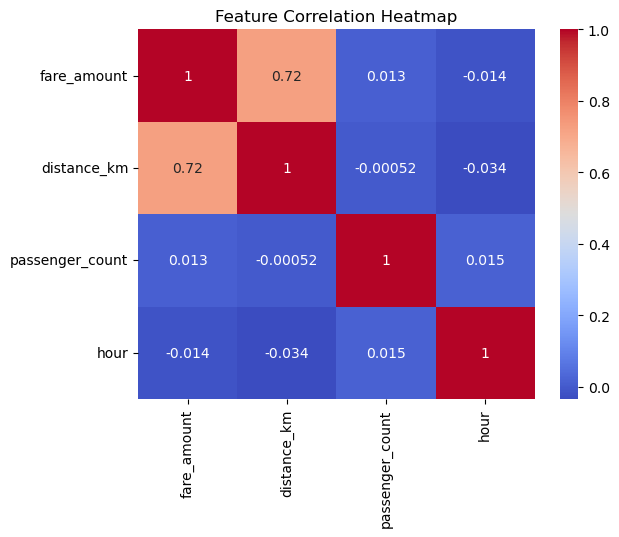

In [280]:
corr = df[['fare_amount', 'distance_km', 'passenger_count', 'hour']].corr()
print("\nCorrelation with Fare Amount:\n", corr['fare_amount'])
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

In [281]:
X = df[['distance_km', 'passenger_count', 'hour']]
y = df['fare_amount']

In [282]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [283]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [284]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [285]:
def evaluate_model(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    
    return pd.Series({'R2': r2, 'RMSE': rmse, 'MAE': mae})

In [286]:
results = pd.DataFrame({
    'Linear Regression': evaluate_model(y_test, y_pred_lr),
    'Random Forest': evaluate_model(y_test, y_pred_rf)
})

In [287]:

results

,Linear Regression,Random Forest
R2,0.549521,0.642763
RMSE,2.769456,2.466239
MAE,1.870457,1.781194


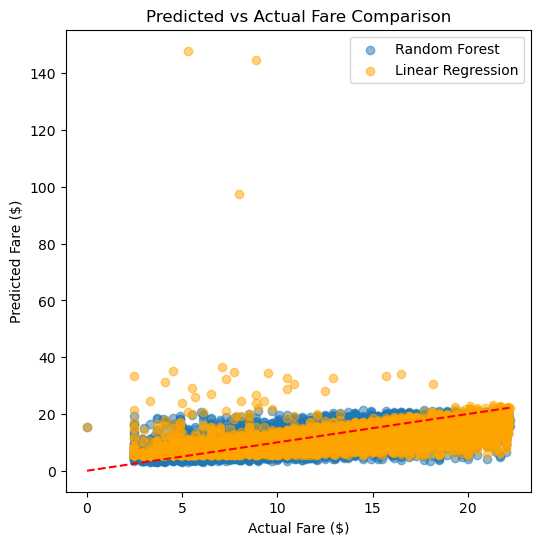

In [288]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, label='Random Forest')
plt.scatter(y_test, y_pred_lr, alpha=0.5, color='orange', label='Linear Regression')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Fare ($)")
plt.ylabel("Predicted Fare ($)")
plt.title("Predicted vs Actual Fare Comparison")
plt.legend()
plt.show()